# Task 1:

Regenerate some results in STORM algorithm paper, https://arxiv.org/pdf/1905.10018.pdf

The results require the use of ResNet model and CIFAR10 datasets.

Hint1: Use the lab GPU to acclerate the training

Hint2: Using torch.optim for other methods (not STORN) is accepted.


In [4]:
import torch
import torch.nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
from torchvision.models import resnet34
from torch.optim.optimizer import Optimizer

In [5]:
## create CFAR10 dataset

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset = datasets.CIFAR10(root='~/datasets/', train=True, download=True, transform=transform)

testset = datasets.CIFAR10(root='~/datasets/', train=False, download=True, transform=transform)


Files already downloaded and verified


Files already downloaded and verified


In [6]:
def train_loop(model, trainloader, testloader, criterion, optimizer, epochs=10, eval_every=1, device="cpu"):
    model = model.to(device)

    train_loss, train_acc = [], []
    test_loss, test_acc = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        for i, data in enumerate(trainloader, 1):

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            ## calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            running_accuracy += correct / total

            if i % 100 == 0:
                print(f"[{epoch + 1}, {i}] TRAIN loss: {(running_loss / i) :.3f} | accuracy: {(running_accuracy / i) * 100 :.1f}")
                train_loss.append(running_loss / i)
                train_acc.append(running_accuracy / i)

        if epoch % eval_every == 0:
            model.eval()
            with torch.no_grad():
                running_loss = 0.0
                total_correct = 0
                total_samples = 0
                for i, data in enumerate(testloader, 0):
                    inputs, labels = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total_correct += (predicted == labels).sum().item()
                    total_samples += labels.size(0)

                average_loss = running_loss / len(testloader)
                accuracy = (total_correct / total_samples) * 100

                print(f"[{epoch + 1}] EVAL loss: {average_loss :.3f} | accuracy: {accuracy :.1f}")
                test_loss.append(average_loss)
                test_acc.append(accuracy / 100)  # Append accuracy as a fraction for consistency

    print("Finished training")
    return train_loss, train_acc, test_loss, test_acc


In [5]:
class STORMOptimizer:
    def __init__(self, params, k=1, w=1, c=1):

        self.params = list(params)

        self.k = k
        self.w = w
        self.c = c
        self.t = 0
        self.a = 0
        self.eta = self.k / (self.w ** (1/3))

        self.d         = [torch.zeros_like(p, device=p.device) for p in self.params]
        self.prev_grad = [torch.zeros_like(p, device=p.device) for p in self.params]
        self.norm_grad = [torch.zeros_like(p, device=p.device) for p in self.params]

        self.g_square_sum = 0
        self.lenPrams = len(self.d)

    def warmup(self, params):
        for i, param in enumerate(params):
            grad = param.grad.data
            self.d[i] = grad
            self.norm_grad[i] = torch.pow(torch.norm(grad), 2)
            param.data = param.data - self.eta * self.d[i]
        self.t += 1

    def step(self):

        if self.t == 0:
            self.warmup(self.params)
            return

        ## if the step is odd
        if self.t % 2 == 1:
            # print("odd step: ", self.t)
            for i, param in enumerate(self.params):
                self.eta = self.k / (self.w + self.norm_grad[i]) ** (1/3)
                grad = param.grad.data

                ## save the previous gradient
                self.prev_grad[i] = grad

                ## update the parameters
                param.data = param.data - self.eta * self.d[i]
                self.a = min(self.c * self.eta ** 2, 1.0)
        else:
            for i, param in enumerate(self.params):
                grad = param.grad.data
                self.norm_grad[i] += torch.pow(torch.norm(grad), 2)
                self.d[i] = grad + (1 - self.a) * (self.d[i] - grad)
        self.t += 1



In [7]:

class StormOptimizer(Optimizer):
    def __init__(self,params,lr=0.1,c=100,momentum={},gradient={},sqrgradnorm={}):
        defaults = dict(lr=lr,c=c,momentum=momentum,sqrgradnorm=sqrgradnorm,gradient=gradient)
        super(StormOptimizer,self).__init__(params,defaults)

    def __setstate__(self,state):
        super(StormOptimizer,self).__setstate__(state)

    def step(self,closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
           learn_rate = group['lr']
           factor = group['c']
           momentum = group['momentum']
           gradient = group['gradient']
           sqrgradnorm = group['sqrgradnorm']

           for p in group['params']:
                # Calculating gradient('∇f(x,ε)' in paper)
                if p.grad is None:
                    continue
                dp = p.grad.data

                # Storing all gradients in a list
                if p in gradient:
                    gradient[p].append(dp)
                else:
                    gradient.update({p:[dp]})

                # Calculating and storing ∑G^2in sqrgradnorm
                if p in sqrgradnorm:
                    sqrgradnorm[p] = sqrgradnorm[p] + torch.pow(torch.norm(dp),2)
                else:
                    sqrgradnorm.update({p:torch.pow(torch.norm(dp),2)})

                # Updating learning rate('η' in paper)
                power = 1.0/3.0
                scaling = torch.pow((0.1 + sqrgradnorm[p]),power)
                learn_rate = learn_rate/(float)(scaling)

                # Calculating 'a' mentioned as a=cη^2 in paper(denoted 'c' as factor here)
                a = min(factor*learn_rate**2.0,1.0)

                # Calculating and storing the momentum term(d'=∇f(x',ε')+(1-a')(d-∇f(x,ε')))
                if p in momentum:
                    momentum[p] = gradient[p][-1] + (1-a)*(momentum[p]-gradient[p][-2])
                else:
                    momentum.update({p:dp})

                # Updation of model parameter p
                p.data = p.data-learn_rate*momentum[p]
                learn_rate = group['lr']

        return loss

In [8]:
batch_size = 32
lr = 0.1

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

criterion = torch.nn.CrossEntropyLoss()

model = resnet34(weights=None)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## train the model
output_adam = train_loop(model, trainloader, testloader, criterion, optimizer, epochs=6, eval_every=1, device="cuda")

[1, 100] TRAIN loss: 3.302 | accuracy: 13.7
[1, 200] TRAIN loss: 2.705 | accuracy: 16.6
[1, 300] TRAIN loss: 2.467 | accuracy: 19.3
[1, 400] TRAIN loss: 2.329 | accuracy: 21.4
[1, 500] TRAIN loss: 2.235 | accuracy: 23.3
[1, 600] TRAIN loss: 2.170 | accuracy: 24.7
[1, 700] TRAIN loss: 2.115 | accuracy: 25.8
[1, 800] TRAIN loss: 2.072 | accuracy: 26.9
[1, 900] TRAIN loss: 2.036 | accuracy: 28.0
[1, 1000] TRAIN loss: 1.997 | accuracy: 29.1
[1, 1100] TRAIN loss: 1.964 | accuracy: 30.1
[1, 1200] TRAIN loss: 1.932 | accuracy: 31.1
[1, 1300] TRAIN loss: 1.905 | accuracy: 31.9
[1, 1400] TRAIN loss: 1.878 | accuracy: 32.9
[1, 1500] TRAIN loss: 1.856 | accuracy: 33.6
[1] EVAL loss: 1.542 | accuracy: 44.8
[2, 100] TRAIN loss: 1.495 | accuracy: 45.6
[2, 200] TRAIN loss: 1.464 | accuracy: 46.5
[2, 300] TRAIN loss: 1.449 | accuracy: 47.0
[2, 400] TRAIN loss: 1.442 | accuracy: 47.5
[2, 500] TRAIN loss: 1.432 | accuracy: 48.1
[2, 600] TRAIN loss: 1.412 | accuracy: 49.1
[2, 700] TRAIN loss: 1.404 | acc

In [9]:
batch_size = 32
lr = 0.1

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# create criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()

model = resnet34(weights=None)

optimizer = StormOptimizer(model.parameters(), lr = lr)


## train the model
output_storm = train_loop(model, trainloader, testloader, criterion, optimizer, epochs=6, eval_every=1, device="cuda")

[1, 100] TRAIN loss: 4.753 | accuracy: 12.0
[1, 200] TRAIN loss: 4.147 | accuracy: 13.8
[1, 300] TRAIN loss: 3.720 | accuracy: 15.0
[1, 400] TRAIN loss: 3.416 | accuracy: 15.6
[1, 500] TRAIN loss: 3.173 | accuracy: 16.5
[1, 600] TRAIN loss: 2.996 | accuracy: 17.7
[1, 700] TRAIN loss: 2.863 | accuracy: 18.3
[1, 800] TRAIN loss: 2.755 | accuracy: 19.0
[1, 900] TRAIN loss: 2.665 | accuracy: 19.6
[1, 1000] TRAIN loss: 2.589 | accuracy: 20.3
[1, 1100] TRAIN loss: 2.521 | accuracy: 21.1
[1, 1200] TRAIN loss: 2.464 | accuracy: 21.7
[1, 1300] TRAIN loss: 2.417 | accuracy: 22.3
[1, 1400] TRAIN loss: 2.375 | accuracy: 22.9
[1, 1500] TRAIN loss: 2.338 | accuracy: 23.4
[1] EVAL loss: 1.753 | accuracy: 35.0
[2, 100] TRAIN loss: 1.742 | accuracy: 31.9
[2, 200] TRAIN loss: 1.729 | accuracy: 34.0
[2, 300] TRAIN loss: 1.728 | accuracy: 34.5
[2, 400] TRAIN loss: 1.722 | accuracy: 35.1
[2, 500] TRAIN loss: 1.716 | accuracy: 35.4
[2, 600] TRAIN loss: 1.707 | accuracy: 35.7
[2, 700] TRAIN loss: 1.700 | acc

In [10]:
batch_size = 32
lr = 0.1

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# create criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()

model = resnet34(weights=None)
model = model.to("cuda")

optimizer = torch.optim.Adagrad(model.parameters(), lr = lr)

## train the model
output_adgrad = train_loop(model, trainloader, testloader, criterion, optimizer, epochs=6, eval_every=1, device="cuda")

[1, 100] TRAIN loss: 2.870 | accuracy: 15.6
[1, 200] TRAIN loss: 2.450 | accuracy: 19.9
[1, 300] TRAIN loss: 2.276 | accuracy: 22.0
[1, 400] TRAIN loss: 2.181 | accuracy: 23.6
[1, 500] TRAIN loss: 2.120 | accuracy: 24.8
[1, 600] TRAIN loss: 2.064 | accuracy: 26.3
[1, 700] TRAIN loss: 2.020 | accuracy: 27.3
[1, 800] TRAIN loss: 1.984 | accuracy: 28.5
[1, 900] TRAIN loss: 1.952 | accuracy: 29.5
[1, 1000] TRAIN loss: 1.923 | accuracy: 30.4
[1, 1100] TRAIN loss: 1.897 | accuracy: 31.3
[1, 1200] TRAIN loss: 1.871 | accuracy: 32.1
[1, 1300] TRAIN loss: 1.846 | accuracy: 32.8
[1, 1400] TRAIN loss: 1.824 | accuracy: 33.6
[1, 1500] TRAIN loss: 1.806 | accuracy: 34.2
[1] EVAL loss: 1.600 | accuracy: 41.9
[2, 100] TRAIN loss: 1.472 | accuracy: 46.0
[2, 200] TRAIN loss: 1.456 | accuracy: 46.5
[2, 300] TRAIN loss: 1.447 | accuracy: 46.5
[2, 400] TRAIN loss: 1.433 | accuracy: 47.3
[2, 500] TRAIN loss: 1.421 | accuracy: 47.8
[2, 600] TRAIN loss: 1.408 | accuracy: 48.3
[2, 700] TRAIN loss: 1.400 | acc

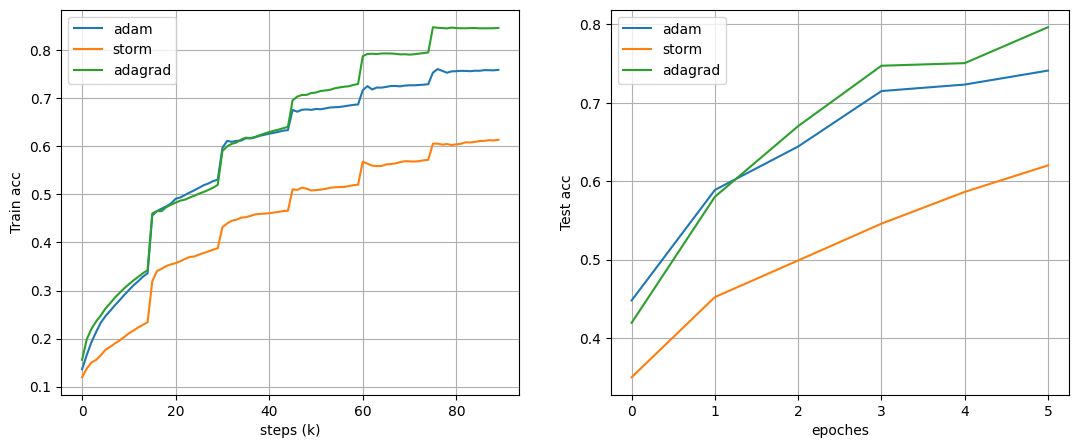

In [11]:

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)

plt.plot(output_adam[1], label="adam")
plt.plot(output_storm[1], label="storm")
plt.plot(output_adgrad[1], label="adagrad")
plt.grid()
plt.legend()
plt.xlabel("steps (k)")
plt.ylabel("Train acc")


plt.subplot(1, 2, 2)
plt.plot(output_adam[3], label="adam")
plt.plot(output_storm[3], label="storm")
plt.plot(output_adgrad[3], label="adagrad")
plt.grid()
plt.legend()
plt.xlabel("epoches")
plt.ylabel("Test acc")
plt.show()

# Task 2:

Adjust the feature scaling property in STORM to other method and compare the results to original STORM.

Hint: You can use methods like e.g. adam, adaDelta


In [12]:
class StormAdamOptimizer(Optimizer):
    def __init__(self, params, lr=0.1, c=100, beta1=0.9, beta2=0.999, epsilon=1e-8):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= epsilon:
            raise ValueError("Invalid epsilon value: {}".format(epsilon))
        if not 0.0 <= beta1 < 1.0:
            raise ValueError("Invalid beta1 parameter: {}".format(beta1))
        if not 0.0 <= beta2 < 1.0:
            raise ValueError("Invalid beta2 parameter: {}".format(beta2))

        defaults = dict(lr=lr, c=c, beta1=beta1, beta2=beta2, epsilon=epsilon,
                        momentum={}, sqrgradnorm={}, gradient={},
                        m={}, v={})
        super(StormAdamOptimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            beta1 = group['beta1']
            beta2 = group['beta2']
            epsilon = group['epsilon']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)

                m, v = state['m'], state['v']
                state['step'] += 1

                # Update first and second moments
                m.mul_(beta1).add_(grad, alpha=1-beta1)
                v.mul_(beta2).addcmul_(grad, grad, value=1-beta2)

                # Compute bias-corrected first and second moment estimates
                m_hat = m / (1 - beta1 ** state['step'])
                v_hat = v / (1 - beta2 ** state['step'])

                # Compute the scaling factor
                scaling_factor = torch.sqrt(v_hat) + epsilon

                # STORM-specific updates
                if p in group['gradient']:
                    group['gradient'][p].append(grad)
                else:
                    group['gradient'][p] = [grad]

                sqr_grad = grad ** 2
                if p in group['sqrgradnorm']:
                    group['sqrgradnorm'][p] += sqr_grad.sum()
                else:
                    group['sqrgradnorm'][p] = sqr_grad.sum()

                power = 1.0 / 3.0
                scaling = torch.pow((0.1 + group['sqrgradnorm'][p]), power)
                adaptive_lr = group['lr'] / scaling

                # Adjust the learning rate using Adam's adaptive method
                adaptive_lr = adaptive_lr / scaling_factor
                adaptive_lr = adaptive_lr / torch.linalg.norm(adaptive_lr)
                # print("dataptive_lr", torch.linalg.norm(adaptive_lr))

                # Update the momentum term
                if 'momentum_buffer' not in state:
                    buf = state['momentum_buffer'] = torch.clone(grad).detach()
                else:
                    buf = state['momentum_buffer']
                    buf.mul_(beta1).add_(grad, alpha=1 - beta1)

                # Corrected update:
                update_value = -adaptive_lr * buf / scaling_factor
                p.data.add_(update_value)

        return loss

In [13]:
batch_size = 32
lr = 0.1

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# create criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()

model =  resnet34(weights=None)
model = model.to("cuda")

optimizer = StormAdamOptimizer(model.parameters(), lr=lr)


## train the model
output_stormAdam = train_loop(model, trainloader, testloader, criterion, optimizer, epochs=6, eval_every=1, device="cuda")

[1, 100] TRAIN loss: 2.452 | accuracy: 24.3
[1, 200] TRAIN loss: 2.112 | accuracy: 29.7
[1, 300] TRAIN loss: 1.963 | accuracy: 32.8
[1, 400] TRAIN loss: 1.864 | accuracy: 35.1
[1, 500] TRAIN loss: 1.791 | accuracy: 37.2
[1, 600] TRAIN loss: 1.730 | accuracy: 39.2
[1, 700] TRAIN loss: 1.670 | accuracy: 41.3
[1, 800] TRAIN loss: 1.613 | accuracy: 43.2
[1, 900] TRAIN loss: 1.557 | accuracy: 45.0
[1, 1000] TRAIN loss: 1.513 | accuracy: 46.4
[1, 1100] TRAIN loss: 1.467 | accuracy: 48.1
[1, 1200] TRAIN loss: 1.428 | accuracy: 49.5
[1, 1300] TRAIN loss: 1.389 | accuracy: 50.9
[1, 1400] TRAIN loss: 1.356 | accuracy: 52.1
[1, 1500] TRAIN loss: 1.322 | accuracy: 53.3
[1] EVAL loss: 0.831 | accuracy: 70.9
[2, 100] TRAIN loss: 0.799 | accuracy: 72.1
[2, 200] TRAIN loss: 0.778 | accuracy: 72.2
[2, 300] TRAIN loss: 0.759 | accuracy: 73.3
[2, 400] TRAIN loss: 0.749 | accuracy: 73.9
[2, 500] TRAIN loss: 0.736 | accuracy: 74.3
[2, 600] TRAIN loss: 0.729 | accuracy: 74.7
[2, 700] TRAIN loss: 0.723 | acc

Text(0, 0.5, 'Train acc')

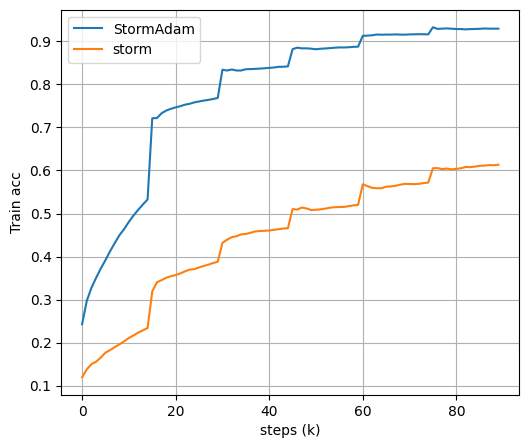

In [14]:
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)

plt.plot(output_stormAdam[1], label="StormAdam")
plt.plot(output_storm[1], label="storm")
plt.grid()
plt.legend()
plt.xlabel("steps (k)")
plt.ylabel("Train acc")

# Task3 :

Discuss the drawback of STORM algorithm (if any) and compare it to ADAM, in terms of convergence speed, and complexity.

The STORM (STOchastic Recursive Momentum) optimization algorithm is a variant of stochastic gradient methods that aims to combine the benefits of both SGD (Stochastic Gradient Descent) with momentum and adaptive learning rate methods like Adam. While it has been shown to perform well in certain contexts, like many optimization algorithms, it is not without its drawbacks.

### Drawbacks of STORM:

1. **Hyperparameter Sensitivity**: STORM introduces a few hyperparameters that need to be carefully tuned. If not properly set, they can significantly affect the convergence and performance of the algorithm.

2. **Complex Update Rule**: STORM's update rule is more complex than simple SGD, incorporating both a recursive form of momentum and an adaptive learning rate. This can make it harder to implement and understand.

3. **Noise Sensitivity**: While STORM is designed to handle noise by adjusting its learning rate, it might still be sensitive to very noisy gradients, which could lead to instability or slower convergence in practice.

4. **Lack of Widespread Adoption**: As a relatively new optimization method, STORM lacks the widespread community testing and support that algorithms like Adam enjoy. This can make it less reliable or harder to troubleshoot in practice.

### Comparison with Adam:

1. **Convergence Speed**:
   - Adam is known for its fast convergence in the early stages of training due to its adaptive learning rates for each parameter.
   - STORM, with its combined momentum and adaptive learning rate approach, aims to provide a good balance between fast convergence and stability. It may not be as fast as Adam initially but could potentially lead to better long-term convergence in some cases.

2. **Complexity**:
   - Adam maintains first and second moment estimates for each parameter, which can be considered relatively complex, although it's generally straightforward to implement.
   - STORM's complexity is comparable to Adam's since it also maintains estimates that are updated at each step, but its recursive nature can make it a bit more involved when it comes to tuning and implementation.

3. **Memory Requirements**:
   - Both Adam and STORM require additional memory to store their respective moment estimates. However, the memory requirement is generally not a significant issue for either algorithm on modern hardware.

4. **Stability and Generalization**:
   - Some studies suggest that while Adam converges faster, it may not generalize as well as SGD with momentum or its variants (which include STORM) on certain tasks.
   - STORM is designed to offer the benefits of both momentum and adaptivity, which could, in theory, lead to better generalization than Adam in some scenarios.
